In [204]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeVigo, FakeBrisbane
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.visualization import plot_histogram
import numpy as np
import math

In [197]:
def c_amodN(a, N, power):
    """Controlled multiplication by a mod N"""
    if a == 1:
        raise ValueError("'a' must be greater than 1")
    elif N % a == 0:
        raise ValueError("'a' must not be a factor of 'N'")
    elif np.gcd(a, N) > 1:
        raise ValueError("'a' and 'N' must not share a factor")
    gate_size = len(np.binary_repr(N))
    gate_max = 2 ** gate_size  - 1
    
    a_bi = np.binary_repr(a)
    a_bi_fixed = np.binary_repr(a, width=gate_size)
    a_bi_floor = 2**len(a_bi) if 2**len(a_bi) == a else 2**(len(a_bi) - 1)
    
    # a + b = "1" * gate_size
    b = gate_max - a
    b_bi = np.binary_repr(b)
    b_bi_fixed = np.binary_repr(b, width=gate_size)
    b_bi_floor = 2**len(b_bi) if 2**len(b_bi) == b else 2**(len(b_bi) - 1)
    
    # plan for swaps
    base_reverse = False if a - a_bi_floor < b - b_bi_floor else True
    swap_base_number = a if not base_reverse else b 
    swap_bi = a_bi if not base_reverse else b_bi
    swap_bi_floor = a_bi_floor if not base_reverse else b_bi_floor
    swap_base = "a"  if not base_reverse else "b"
    
    swap_dist = len(swap_bi) - 1
    swap_order = "backward"
    if swap_bi_floor > ((gate_max + 1) / 4):
        swap_dist = gate_size - swap_dist
        swap_order = "forward"
    n_swaps = gate_size - swap_dist
        
    U = QuantumCircuit(gate_size)
    
    for _iteration in range(power):
        init_state = np.zeros(gate_size, dtype="int")
        init_state[0] = 1
        swaped_state_number = 1
        for i in range(n_swaps):
            if swap_order == "backward":
                x = gate_size - i - swap_dist - 1
                y = gate_size - i - 1
            elif swap_order == "forward":
                x = i
                y = i + swap_dist
            init_state[[x, y]] = init_state[[y, x]]
            swaped_state_number = int(''.join(map(str, np.flip(init_state))), 2)
            if swaped_state_number > swap_base_number:
                init_state[[x, y]] = init_state[[y, x]]
                swaped_state_number = int(''.join(map(str, np.flip(init_state))), 2)
                break
            else:
                U.swap(x, y)
        if swaped_state_number == a:
            pass
        elif gate_max - swaped_state_number == a:
            for q in range(gate_size):
                U.x(q)
        else:
            for j in range(gate_size):
                if init_state[j] != int(a_bi_fixed[gate_size - j - 1]):
                    U.x(j)
    U = U.to_gate()
    U.name = f"{a}^{power} mod {N}" 
    c_U = U.control()
    return c_U

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [201]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 2

In [202]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amodN(a, 15, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  2^1 mod 15 ││  2^2 mod 15 ││  2^4 mod 15 ││  2^8 mod 15 ││  2^16 mod 15 ││  2^32 mod 15 ││  2^64 mod 15 ││  2^128 mod 15 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ─────┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

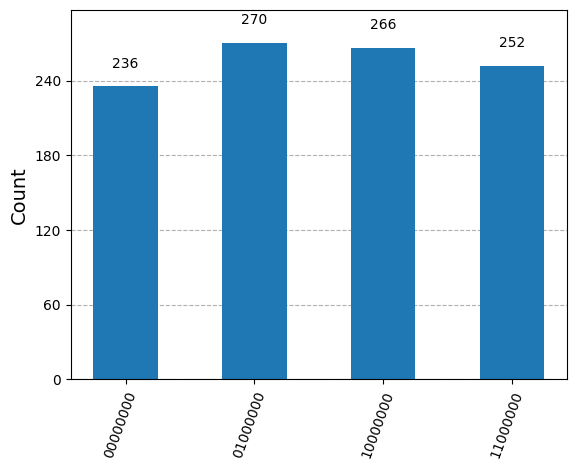

In [203]:
aer_sim = AerSimulator()
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [5]:
# backend and optimizer
optimization_level = 1
backend = qiskit_aer.AerSimulator.from_backend(FakeBrisbane())
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)

# pass manager and run
transpiled = pass_manager.run(qc)
job = backend.run(transpiled)

In [92]:
U = QuantumCircuit(4)
k = 7
for _iteration in range(2):
    if k in [2,13]:
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
    if k in [7,8]:
        U.swap(0,1)
        U.swap(1,2)
        U.swap(2,3)
    if k in [4, 11]:
        U.swap(1,3)
        U.swap(0,2)
    if k in [7,11,13]:
        for q in range(4):
            U.x(q)
U.draw()

┌───┐          ┌───┐          
q_0: ─X─┤ X ├───────X──┤ X ├──────────
      │ └───┘┌───┐  │  └───┘┌───┐     
q_1: ─X───X──┤ X ├──X────X──┤ X ├─────
          │  └───┘┌───┐  │  └───┘┌───┐
q_2: ─────X────X──┤ X ├──X────X──┤ X ├
               │  ├───┤       │  ├───┤
q_3: ──────────X──┤ X ├───────X──┤ X ├
                  └───┘          └───┘

In [196]:
def c_amodN(a, N, power):
    """Controlled multiplication by a mod N"""
    if a == 1:
        raise ValueError("'a' must be greater than 1")
    elif N % a == 0:
        raise ValueError("'a' must not be a factor of 'N'")
    elif np.gcd(a, N) > 1:
        raise ValueError("'a' and 'N' must not share a factor")
    gate_size = len(np.binary_repr(N))
    gate_max = 2 ** gate_size  - 1
    
    a_bi = np.binary_repr(a)
    a_bi_fixed = np.binary_repr(a, width=gate_size)
    a_bi_floor = 2**len(a_bi) if 2**len(a_bi) == a else 2**(len(a_bi) - 1)
    
    # a + b = "1" * gate_size
    b = gate_max - a
    b_bi = np.binary_repr(b)
    b_bi_fixed = np.binary_repr(b, width=gate_size)
    b_bi_floor = 2**len(b_bi) if 2**len(b_bi) == b else 2**(len(b_bi) - 1)
    
    # plan for swaps
    base_reverse = False if a - a_bi_floor < b - b_bi_floor else True
    swap_base_number = a if not base_reverse else b 
    swap_bi = a_bi if not base_reverse else b_bi
    swap_bi_floor = a_bi_floor if not base_reverse else b_bi_floor
    swap_base = "a"  if not base_reverse else "b"
    
    swap_dist = len(swap_bi) - 1
    swap_order = "backward"
    if swap_bi_floor > ((gate_max + 1) / 4):
        swap_dist = gate_size - swap_dist
        swap_order = "forward"
    n_swaps = gate_size - swap_dist
        
    U = QuantumCircuit(gate_size)
    
    for _iteration in range(power):
        init_state = np.zeros(gate_size, dtype="int")
        init_state[0] = 1
        swaped_state_number = 1
        for i in range(n_swaps):
            if swap_order == "backward":
                x = gate_size - i - swap_dist - 1
                y = gate_size - i - 1
            elif swap_order == "forward":
                x = i
                y = i + swap_dist
            init_state[[x, y]] = init_state[[y, x]]
            swaped_state_number = int(''.join(map(str, np.flip(init_state))), 2)
            if swaped_state_number > swap_base_number:
                init_state[[x, y]] = init_state[[y, x]]
                swaped_state_number = int(''.join(map(str, np.flip(init_state))), 2)
                break
            else:
                U.swap(x, y)
        if swaped_state_number == a:
            pass
        elif gate_max - swaped_state_number == a:
            for q in range(gate_size):
                U.x(q)
        else:
            for j in range(gate_size):
                if init_state[j] != int(a_bi_fixed[gate_size - j - 1]):
                    U.x(j)
        
        
    return U

c_amodN(13, 15, 1).draw()

5 0
4 2 2 1 backward 3
2


┌───┐
q_0: ──────────X──┤ X ├
               │  ├───┤
q_1: ─────X────X──┤ X ├
          │  ┌───┐└───┘
q_2: ─X───X──┤ X ├─────
      │ ┌───┐└───┘     
q_3: ─X─┤ X ├──────────
        └───┘

In [63]:
O = QuantumCircuit(4)
O.x([0, 2, 3])
O.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     └───┘

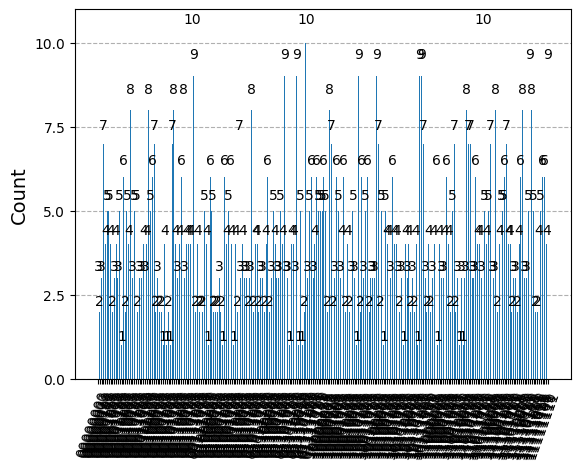

In [10]:
from qiskit.visualization import plot_histogram

plot_histogram(job.result().get_counts())

In [ ]:
transpiled.draw()